In [303]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import re
data = pd.read_csv('../fobokiller/data/scrapping_cleaned.csv',nrows=20000,index_col=0)
data.head()
#from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [304]:
data

,alias,date,rate,review,review_clean
0,le-sud-paris,2018-11-20,5,"Ed W.\nElite 2021\nMiami, FL\n259\n562\n4232\n...",traditional parisian cooking style restaurant ...
1,le-sud-paris,2021-07-04,2,"Jaki F.\nElite 2021\nSignal Hill, CA\n358\n270...",im sure happening restaurant excited dine serv...
2,le-sud-paris,2018-06-20,3,"Jen S.\nElite 2021\nBuffalo, NY\n71\n322\n809\...",ambience enticing end day definitely directed ...
3,le-sud-paris,2015-09-28,3,"Sam S.\nElite 2021\nMunich, Germany\n2133\n255...",ambience star opinion expensive tourist trap m...
4,le-sud-paris,2019-08-08,1,"Fahad A.\nLos Angeles, CA\n0\n10\n15\n8/8/2019...",worst restaurant ever servers help us food bla...
...,...,...,...,...,...
19995,flottes-paris,2016-07-18,5,"Mary W.\nFlossmoor, IL\n78\n15\n55\n7/18/2016\...",four night stay hotel castille famous rue camb...
19996,flottes-paris,2019-07-09,5,"Alexei R.\nMountain View, CA\n49\n15\n4\n7/9/2...",stopped steak tartare entire meal amazing oyst...
19997,flottes-paris,2019-06-10,4,"Tierra H.\nAltadena, CA\n29\n63\n20\n6/10/2019...",french onion soup amazing place take reservati...
19998,flottes-paris,2016-01-25,4,"Steven H.\nElite 2021\nMadison, NJ\n404\n491\n...",ate twice recent trip paris first meal late lu...


In [307]:
data['review_list'] = data.review_clean.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

<>:4: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
/var/folders/s6/nxj_k6112bj7cnd89_8b9l0c0000gn/T/ipykernel_20220/1624601247.py:4: DeprecationWarning: invalid escape sequence \s
  data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]


In [308]:
#function to keep digit from rate string
def keep_digit(rate):
    for char in rate.split():
        if char.isdigit():
            return int(char)
    pass

In [309]:
tokens_reviews = list(sent_to_words(data['review_list']))

In [310]:
tokens_reviews = make_n_grams(tokens_reviews)

In [311]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',                                                                                                       'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [312]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])
#reviews_lemmatized = tokens_reviews
# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

# LDA-model

In [318]:
id2word = corpora.Dictionary(reviews_lemmatized)
id2word.filter_extremes(no_above=0.15,)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [319]:
# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [320]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 1, limit = 60, step = 2)

model created


0.34058641293199254
model created
0.3615034055606488


model created
0.35769963561925044


model created
0.3617154506122445


model created
0.3626198445253166


model created
0.3586585499219005


model created
0.37514597835848057


model created
0.36309308117720535


model created
0.37266645899956147


model created
0.3751656354898931


model created
0.3732635549310779


model created
0.3654732424433858


model created
0.3832058818546768


model created
0.37264550765874643


model created
0.3740390470853781


model created
0.35340749437012786


model created
0.37023665914563164


model created
0.36211759346305245


model created
0.36401320320376723


model created
0.3409523218274702


model created
0.36032298482721264


model created
0.3560232546650832


model created
0.34673489740591124


model created
0.34134879790695


model created
0.3482809616306791


model created
0.3673855835755009


model created
0.34542647118529246


model created
0.3295894204563602


model created
0.35218225473212034


model created
0.3366784558551045


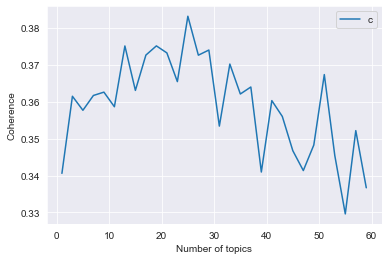

In [321]:
limit, start, step = 60, 1, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [322]:
id2word = corpora.Dictionary(reviews_lemmatized)
id2word.filter_extremes(no_above=0.05,)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 1, limit = 60, step = 2)

model created


0.16293118147682784
model created
0.18668422701178608


model created
0.24162480500423653


model created
0.23407290740061


model created
0.24537061656280423


model created
0.25994835613217177


model created
0.25852440113553743


model created
0.2777269632615616


model created
0.2700812856584117


model created
0.27659179418211083


model created
0.27167526873461983


model created
0.26740431830303996


model created
0.27448555898763927


model created
0.2671241536296909


model created
0.3154945600765324


model created
0.2800393355937426


model created
0.2812762520392961


model created
0.27917674837226386


model created
0.29973956390210493


model created
0.28401670265852835


model created
0.285045016080651


model created
0.2933763541547047


model created
0.2959895363027225


model created
0.29855788305973957


model created
0.2948811590801891


model created
0.34597166936079027


model created
0.3581970748850036


model created
0.32322978243091227


model created
0.3644571025465893


model created
0.31575434053681517


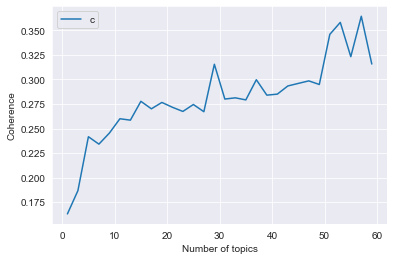

In [323]:
limit, start, step = 60, 1, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [324]:
id2word = corpora.Dictionary(reviews_lemmatized)
id2word.filter_extremes(no_above=0.20,)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

id2word = corpora.Dictionary(reviews_lemmatized)
id2word.filter_extremes(no_above=0.20,)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 1, limit = 60, step = 2)model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 1, limit = 60, step = 2)

model created


0.3694517341119225
model created


0.4047585768335505
model created
0.40974810546709783


model created
0.43189302672943397


model created
0.3909380535811061


model created
0.40989566086659085


model created
0.40002929651002683


model created
0.40474279789789736


model created
0.41848301031731644


model created
0.4123121044524809


model created
0.3956163988046164


model created
0.4090879236136341


model created
0.40024431158714546


model created
0.4155398783051421


model created
0.39178952992062405


model created
0.39901573850523075


model created
0.3890363273291712


model created
0.37171344693901653


model created
0.3659038327444125


model created
0.3739375436937069


model created
0.388667182566259


model created
0.38318505743187414


model created
0.36595331292442823


model created
0.36682705693664186


model created
0.3572775420026519


model created
0.3808464227106667


model created
0.3856153802545576


model created
0.35156721482232495


model created
0.3680288857538911


model created
0.3504632751286707


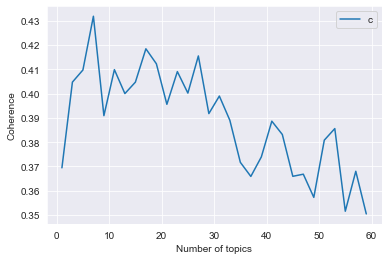

In [325]:


limit, start, step = 60, 1, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [326]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(0,
  '0.006*"wine" + 0.005*"staff" + 0.005*"eat" + 0.004*"meal" + 0.004*"atmosphere" + 0.004*"taste" + 0.004*"try" + 0.004*"wait" + 0.004*"server" + 0.004*"visit"'),
 (1,
  '0.006*"recommend" + 0.006*"price" + 0.005*"meal" + 0.005*"wine" + 0.005*"dessert" + 0.005*"staff" + 0.005*"definitely" + 0.005*"menu" + 0.005*"try" + 0.004*"dinner"'),
 (2,
  '0.006*"wine" + 0.005*"meal" + 0.005*"eat" + 0.005*"wait" + 0.005*"try" + 0.004*"dinner" + 0.004*"steak" + 0.004*"dish" + 0.004*"bit" + 0.004*"table"'),
 (3,
  '0.007*"staff" + 0.006*"wine" + 0.005*"sandwich" + 0.005*"try" + 0.005*"breakfast" + 0.005*"love" + 0.005*"ve" + 0.005*"taste" + 0.004*"price" + 0.004*"menu"'),
 (4,
  '0.005*"price" + 0.005*"wine" + 0.005*"table" + 0.005*"eat" + 0.005*"meal" + 0.005*"menu" + 0.004*"dinner" + 0.004*"experience" + 0.004*"try" + 0.004*"waiter"'),
 (5,
  '0.006*"pizza" + 0.006*"wine" + 0.005*"try" + 0.005*"staff" + 0.005*"love" + 0.005*"definitely" + 0.005*"menu" + 0.005*"visit" + 0.004*"experience" + 0.

In [260]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [261]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9534,"burger, come, price, staff, bit, food, visit, ...","[cooking, style, restaurant, cuisine, look, bo..."
1,1,0.0,0.9498,"steak, try, food, set, waiter, staff, burger, ...","[sure, happen, restaurant, dine, service, rest..."
2,2,2.0,0.9470,"burger, come, price, staff, bit, food, visit, ...","[ambience, enticing, end, definitely, direct, ..."
3,3,1.0,0.9576,"pastrami, plate, sandwich, place, enjoy, meal,...","[ambience, opinion, tourist, trap, moment, ent..."
4,4,3.0,0.8920,"server, restaurant, service, cook, place, burg...","[restaurant, server, help, food, tasteless, re..."
5,5,0.0,0.9232,"steak, try, food, set, waiter, staff, burger, ...","[block, hotel, know, steak, tartare, disappoin..."
6,6,2.0,0.9342,"burger, come, price, staff, bit, food, visit, ...","[dinner, come, bread, come, depth, flavor, cro..."
7,7,3.0,0.9126,"server, restaurant, service, cook, place, burg...","[plate, year, ago, surprise, remove, quality, ..."
8,8,3.0,0.9094,"server, restaurant, service, cook, place, burg...","[service, rib, steak, kind, cook, fact, waiter..."
9,9,0.0,0.8832,"steak, try, food, set, waiter, staff, burger, ...","[star, cause, service, order, steak, come, ord..."


In [262]:
df_dominant_topic.to_csv("without_lemmatizing.csv")

In [263]:
df_dominant_topic["Dominant_Topic"].unique()

array([2., 0., 1., 3.])

In [264]:
data["nonLem"] = reviews_lemmatized
data

,alias,date,rate,review,review_clean,length,review_list,nonLem
0,le-sud-paris,2018-11-20,5,"Ed W.\nElite 2021\nMiami, FL\n259\n562\n4232\n...",traditional parisian cooking style restaurant ...,97,traditional parisian cooking style restaurant ...,"[cooking, style, restaurant, cuisine, look, bo..."
1,le-sud-paris,2021-07-04,2,"Jaki F.\nElite 2021\nSignal Hill, CA\n358\n270...",im sure happening restaurant excited dine serv...,65,im sure happening restaurant excited dine serv...,"[sure, happen, restaurant, dine, service, rest..."
2,le-sud-paris,2018-06-20,3,"Jen S.\nElite 2021\nBuffalo, NY\n71\n322\n809\...",ambience enticing end day definitely directed ...,59,ambience enticing end day definitely directed ...,"[ambience, enticing, end, definitely, direct, ..."
3,le-sud-paris,2015-09-28,3,"Sam S.\nElite 2021\nMunich, Germany\n2133\n255...",ambience star opinion expensive tourist trap m...,118,ambience star opinion expensive tourist trap m...,"[ambience, opinion, tourist, trap, moment, ent..."
4,le-sud-paris,2019-08-08,1,"Fahad A.\nLos Angeles, CA\n0\n10\n15\n8/8/2019...",worst restaurant ever servers help us food bla...,14,worst restaurant ever servers help us food bla...,"[restaurant, server, help, food, tasteless, re..."
...,...,...,...,...,...,...,...,...
95,un-air-de-famille-paris-2,2014-07-30,4,"Cheryl H.\nBurbank, Los Angeles, CA\n350\n58\n...",finally food stop terrible meals paris contemp...,44,finally food stop terrible meals paris contemp...,"[finally, food, stop, meal, contemplate, mcdon..."
96,un-air-de-famille-paris-2,2014-03-24,3,"David M.\nNashville, TN\n1387\n33\n8\n3/24/201...",nice find spot beaten tourist path make sure t...,11,nice find spot beaten tourist path make sure t...,"[spot, beat, tourist, path, translator, din, a..."
97,oresto-paris-3,2016-04-24,4,"Kelly N.\nWashington, DC\n7\n19\n2\n4/24/2016\...",cozy cafe nice vibe playing latin music whole ...,23,cozy cafe nice vibe playing latin music whole ...,"[cafe, vibe, play, music, love, oresto, sample..."
98,oresto-paris-3,2019-11-24,3,"Doug C.\nElite 2021\nPlano, TX\n1\n764\n7892\n...",blocks hotel nice little small french restaura...,18,blocks hotel nice little small french restaura...,"[block, hotel, restaurant, meal, service, expe..."


In [265]:
tf_idf_vectorizer = TfidfVectorizer(max_features = 50)

X = tf_idf_vectorizer.fit_transform(data['review_clean'])

X.toarray()

pd.DataFrame(X.toarray(),columns = tf_idf_vectorizer.get_feature_names())

/Users/manoharan/.pyenv/versions/3.8.12/envs/FOBO/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,also,back,beef,bit,burger,burgers,came,cheese,de,delicious,...,staff,table,time,try,us,waiter,well,went,wine,would
0,0.206252,0.000000,0.000000,0.000000,0.0,0.0,0.211388,0.0,0.216935,0.160735,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.192796,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.341898,0.0,0.000000,0.0,0.335530,0.0,0.000000,0.00000,0.348593,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.275552,0.0,0.000000,0.0,0.000000,0.0,0.292649,0.32087,0.000000,0.000000
3,0.414281,0.202338,0.000000,0.185885,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.169625,0.0,0.000000,0.0,0.000000,0.00000,0.185885,0.193627
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.668142,0.0,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.239793,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.287624
96,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
97,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.536665,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
98,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000


In [266]:
data2 = data.groupby('alias').agg({'review_clean' : ' '.join})  

In [267]:
data2

,review_clean
alias,
la-romantica-clichy,im italian hard core im bewildered reviews peo...
le-dome-paris-13,first dining experience paris le dome walking ...
le-durand-dupont-neuilly-sur-seine,brunchbreakfast rainy neuilly market day quite...
le-petit-villiers-paris-2,small cafe wagman area paris right across metr...
le-sud-paris,traditional parisian cooking style restaurant ...
oresto-paris-3,cozy cafe nice vibe playing latin music whole ...
schwartzs-deli-paris-5,came schwartzs looking take bit break french c...
un-air-de-famille-paris-2,stopped around rainy friday night quite table ...


In [268]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.12)
vectorizer.fit(data2['review_clean'])

data_vectorized = vectorizer.transform(data2['review_clean'])

lda_model = LatentDirichletAllocation(n_components=6).fit(data_vectorized)

def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(lda_model, vectorizer)

Topic 0:
[('low', 0.16667203055152816), ('amazing', 0.16667166935213276), ('end', 0.16667158568074084), ('surprised', 0.166671503301233), ('experience', 0.16667150170739092), ('enjoyed', 0.16667148069508958), ('day', 0.16667137463140227), ('rich', 0.16667136493753615), ('hot', 0.16667135329667357), ('lovely', 0.16667135324080276)]
Topic 1:
[('good', 0.7152493524327097), ('food', 0.6458887510465938), ('nice', 0.6274613999379883), ('burger', 0.615075895439986), ('menu', 0.5725930333044262), ('french', 0.569703634949571), ('restaurant', 0.547863569294119), ('great', 0.5339624766782297), ('service', 0.5285346719904848), ('like', 0.5233209824627415)]
Topic 2:
[('low', 0.16667203055267316), ('amazing', 0.1666716693521188), ('end', 0.16667158568061557), ('surprised', 0.16667150330127217), ('experience', 0.16667150170728873), ('enjoyed', 0.16667148069548499), ('day', 0.16667137463127654), ('rich', 0.1666713649373183), ('hot', 0.16667135329665933), ('lovely', 0.16667135324139984)]
Topic 3:
[('l

/Users/manoharan/.pyenv/versions/3.8.12/envs/FOBO/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [269]:
!pwd

/Users/manoharan/code/fobokiller/notebooks
